In [1]:
import quandl

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
price_table = quandl.get_table('SHARADAR/SEP', 
                               ticker=['AMD', 'NVDA',
                                       'BAC', 'C',
                                       'FB', 'AMZN', 'NFLX',
                                       'F', 'GM',
                                       'T', 'CMCSA', 'DIS',
                                       'AAPL', 'MSFT', 
                                       'FCX', 'SIRI',
                                       'NUS', 'EL',
                                       'MU', 'INTC',
                                       'UAL', 'AAL',
                                       'TRIP', 'BKNG',
                                       'KO', 'PEP',
                                       'XOM', 'CVX'
                                      ]
                               , paginate=True)

In [3]:
sorted_table = price_table.sort_values(by=['ticker','date'], ascending=True).copy()
tickers = sorted(list(set(sorted_table['ticker'])))
price_stock = price_table[price_table['ticker']==tickers[0]][['date','close']].sort_values(by='date', ascending=True)
price_stock.reset_index(inplace=True)

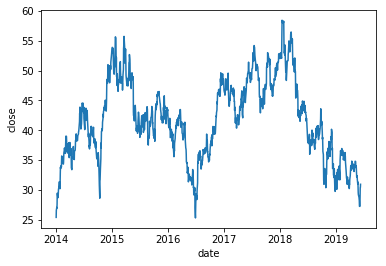

In [4]:
sns.lineplot(x='date', y='close', data=price_stock)

In [5]:
close_df = pd.DataFrame()
close_df['date'] = price_stock['date']
volume_df = pd.DataFrame()
close_df['date'] = price_stock['date']

for ticker in tickers:
    close_df[ticker] = list(sorted_table[sorted_table['ticker']==ticker]['close'])
    volume_ticker = 'v_' + ticker
    volume_df[volume_ticker] = list(sorted_table[sorted_table['ticker']==ticker]['volume'])

no_date_df = close_df[list(close_df.columns)[1:]]
return_df = no_date_df/no_date_df.shift(1) - 1

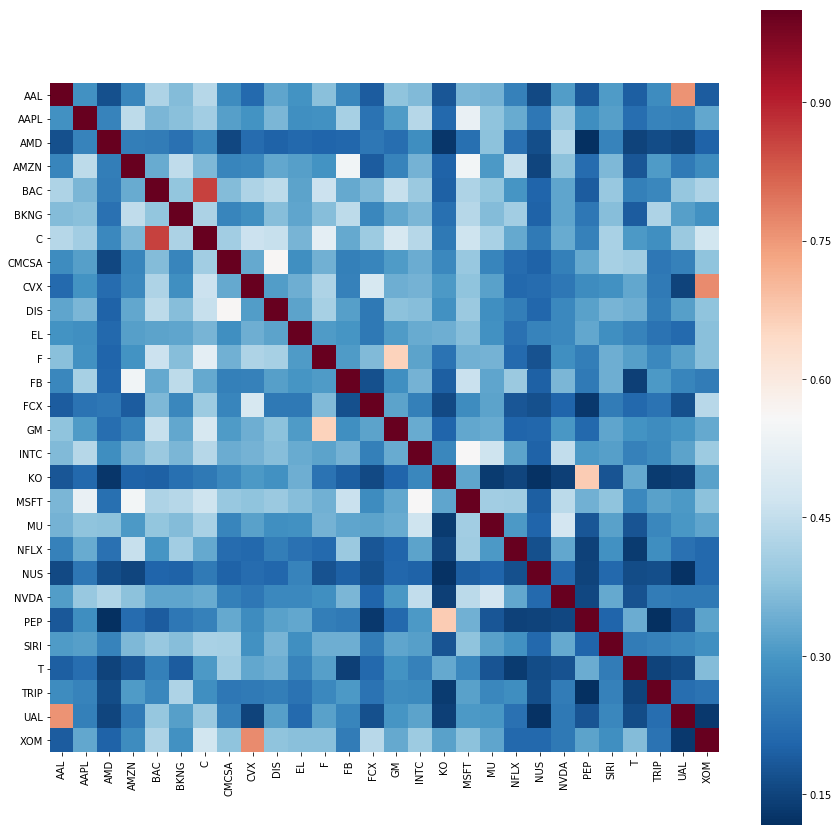

In [6]:
stock_corr = return_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(stock_corr, square=True, cmap="RdBu_r");

In [196]:
train_perc = 0.40

return_df_2 = pd.concat([return_df, volume_df], axis=1)

train_len = int(return_df.shape[0] * (train_perc))
stocks_to_trade = ['BAC','C']
volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
for i in volume_to_trade:
    stocks_to_trade.append(i)

train = return_df_2[stocks_to_trade][1:train_len].copy()
train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
train.reset_index(inplace=True, drop=True)

test = return_df_2[stocks_to_trade][train_len:-400].copy()
test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
test.reset_index(inplace=True, drop=True)

true_test = return_df_2[stocks_to_trade][-400:].copy()
true_test['diff'] = true_test[stocks_to_trade[0]] - true_test[stocks_to_trade[1]]
true_test.reset_index(inplace=True, drop=True)

feature_names = volume_to_trade
feature_names.append('diff')

In [197]:
def make_variables(dataset, lags, look_back, predict_window):
    features = lags+1
    start = look_back
    stop = len(dataset) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, features

In [310]:
# Create and fit the LSTM network

dataset = np.matrix(train[feature_names])
lags = 30
look_back = 3        # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)

train_X = lstm_in_X
train_Y = lstm_in_Y

model = Sequential()
model.add(LSTM(16, input_shape=(look_back+1, features)))
model.add(Dropout(0.2))
model.add(Dense(look_back+1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(train_X, train_Y, epochs=100, batch_size=25, verbose=1)

Epoch 1/100
511/511 [==============================] - 4s 8ms/step - loss: 0.0065
Epoch 2/100
511/511 [==============================] - 0s 333us/step - loss: 0.0062
Epoch 3/100
511/511 [==============================] - 0s 232us/step - loss: 0.0059
Epoch 4/100
511/511 [==============================] - 0s 233us/step - loss: 0.0058
Epoch 5/100
511/511 [==============================] - 0s 237us/step - loss: 0.0057
Epoch 6/100
511/511 [==============================] - 0s 226us/step - loss: 0.0056
Epoch 7/100
511/511 [==============================] - 0s 218us/step - loss: 0.0054
Epoch 8/100
511/511 [==============================] - 0s 221us/step - loss: 0.0053
Epoch 9/100
511/511 [==============================] - 0s 220us/step - loss: 0.0053
Epoch 10/100
511/511 [==============================] - 0s 222us/step - loss: 0.0052
Epoch 11/100
511/511 [==============================] - 0s 226us/step - loss: 0.0051
Epoch 12/100
511/511 [==============================] - 0s 229us/step - loss

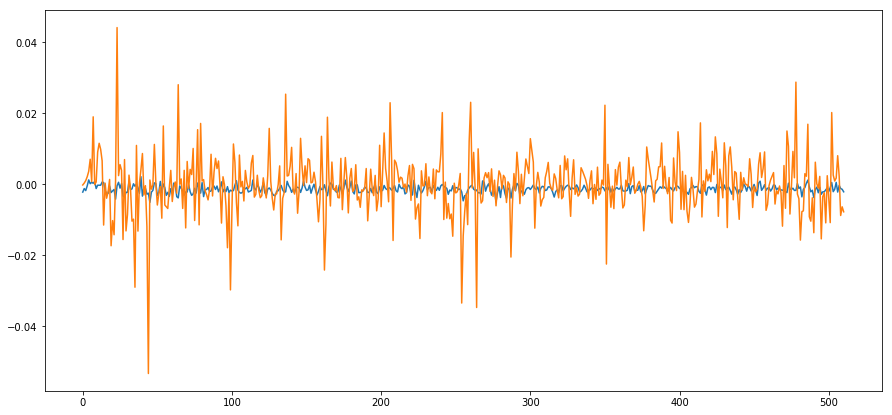

In [322]:
pred_Y_train = model.predict(train_X)
predictions = pred_Y_train[:,-1]
actuals = train_Y[:,-1]

fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(predictions)
plt.plot(actuals)

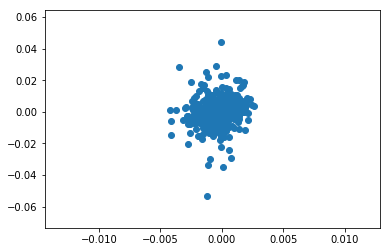

In [206]:
plt.scatter(x=predictions, y=actuals)

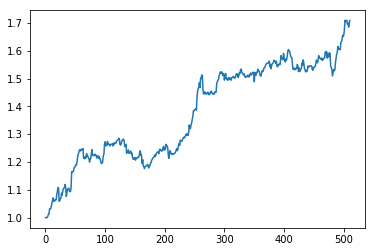

In [207]:
init = 100
position = []
for i, val in enumerate(list(predictions)):
    if val >= 0:
        position.append(1)
    else:
        position.append(-1)
        
plt.plot(np.cumprod((np.array(position)*actuals)+1));

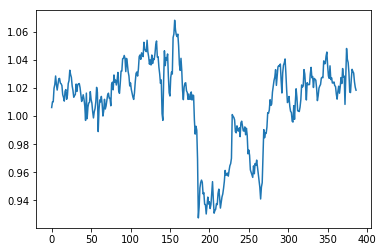

In [209]:
# Quick (non-expanding) backtest for sanity checking

dataset = np.matrix(test[feature_names])
lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    
test_X = lstm_in_X
test_Y = lstm_in_Y

pred_Y_test = model.predict(test_X)
predictions_test = pred_Y_test[:,-1]
actuals_test = test_Y[:,-1]

init = 100
position_test = []
for i, val in enumerate(list(predictions_test)):
    if val >= 0:
        position_test.append(1)
    else:
        position_test.append(-1)
        
plt.plot(np.cumprod((np.array(position_test)*actuals_test)+1));

In [ ]:
# Expanding window test where I fit the model again every day

dataset = np.matrix(train[feature_names])
expand_set = np.matrix(test[feature_names])

lags = 30
look_back = 3        # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

predictions_test = []
actuals_test = []

print(expand_set.shape[0] - 1)

for i in range(0, expand_set.shape[0] - 1):
    print(i)
    curr_row = expand_set[i]
    test_row = expand_set[i+1]
    dataset = np.append(dataset, curr_row, axis=0)
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y
    
    # Fit the data all the way up to curr_row (today)
    model = Sequential()
    model.add(LSTM(16, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(train_X, train_Y, epochs=33, batch_size=25, verbose=1)
    
    # Predict the next day (out of sample) - data for next day is in test_row
    dataset_test = np.append(dataset, test_row, axis=0)
    lstm_in_X_test, lstm_in_Y_test, features = make_variables(dataset_test, lags, look_back, predict_window)
    test_X = lstm_in_X_test
    pred_Y_test = model.predict(test_X)
    predict_test = pred_Y_test[-1,-1]
    actual_test = test_row[-1,-1]
    # Store predictions and actuals to for calculating money made and plotting
    predictions_test.append(predict_test)
    actuals_test.append(actual_test)

420
0
Epoch 1/33
512/512 [==============================] - 34s 66ms/step - loss: 0.0065
Epoch 2/33
512/512 [==============================] - 0s 532us/step - loss: 0.0062
Epoch 3/33
512/512 [==============================] - 0s 587us/step - loss: 0.0060
Epoch 4/33
512/512 [==============================] - 0s 497us/step - loss: 0.0059
Epoch 5/33
512/512 [==============================] - 0s 446us/step - loss: 0.0057
Epoch 6/33
512/512 [==============================] - 0s 468us/step - loss: 0.0055
Epoch 7/33
512/512 [==============================] - 0s 474us/step - loss: 0.0053
Epoch 8/33
512/512 [==============================] - 0s 446us/step - loss: 0.0053
Epoch 9/33
512/512 [==============================] - 0s 450us/step - loss: 0.0052
Epoch 10/33
512/512 [==============================] - 0s 444us/step - loss: 0.0050
Epoch 11/33
512/512 [==============================] - 0s 453us/step - loss: 0.0050
Epoch 12/33
512/512 [==============================] - 0s 447us/step - loss: 0.

Epoch 31/33
517/517 [==============================] - 0s 502us/step - loss: 0.0031
Epoch 32/33
517/517 [==============================] - 0s 510us/step - loss: 0.0030
Epoch 33/33
517/517 [==============================] - 0s 424us/step - loss: 0.0030
6
Epoch 1/33
518/518 [==============================] - 36s 70ms/step - loss: 0.0065
Epoch 2/33
518/518 [==============================] - 0s 424us/step - loss: 0.0061
Epoch 3/33
518/518 [==============================] - 0s 423us/step - loss: 0.0059
Epoch 4/33
518/518 [==============================] - 0s 426us/step - loss: 0.0057
Epoch 5/33
518/518 [==============================] - 0s 425us/step - loss: 0.0056
Epoch 6/33
518/518 [==============================] - 0s 423us/step - loss: 0.0055
Epoch 7/33
518/518 [==============================] - 0s 425us/step - loss: 0.0053
Epoch 8/33
518/518 [==============================] - 0s 423us/step - loss: 0.0052
Epoch 9/33
518/518 [==============================] - 0s 426us/step - loss: 0.0051

523/523 [==============================] - 0s 425us/step - loss: 0.0032
Epoch 28/33
523/523 [==============================] - 0s 421us/step - loss: 0.0031
Epoch 29/33
523/523 [==============================] - 0s 425us/step - loss: 0.0029
Epoch 30/33
523/523 [==============================] - 0s 425us/step - loss: 0.0029
Epoch 31/33
523/523 [==============================] - 0s 424us/step - loss: 0.0027
Epoch 32/33
523/523 [==============================] - 0s 427us/step - loss: 0.0027
Epoch 33/33
523/523 [==============================] - 0s 420us/step - loss: 0.0027
12
Epoch 1/33
524/524 [==============================] - 35s 67ms/step - loss: 0.0063
Epoch 2/33
524/524 [==============================] - 0s 501us/step - loss: 0.0060
Epoch 3/33
524/524 [==============================] - 0s 492us/step - loss: 0.0056
Epoch 4/33
524/524 [==============================] - 0s 502us/step - loss: 0.0055
Epoch 5/33
524/524 [==============================] - 0s 503us/step - loss: 0.0054
Epoch 

529/529 [==============================] - 0s 453us/step - loss: 0.0033
Epoch 24/33
529/529 [==============================] - 0s 445us/step - loss: 0.0031
Epoch 25/33
529/529 [==============================] - 0s 459us/step - loss: 0.0030
Epoch 26/33
529/529 [==============================] - 0s 469us/step - loss: 0.0029
Epoch 27/33
529/529 [==============================] - 0s 451us/step - loss: 0.0028
Epoch 28/33
529/529 [==============================] - 0s 446us/step - loss: 0.0028
Epoch 29/33
529/529 [==============================] - 0s 470us/step - loss: 0.0027
Epoch 30/33
529/529 [==============================] - 0s 477us/step - loss: 0.0026
Epoch 31/33
529/529 [==============================] - 0s 457us/step - loss: 0.0028
Epoch 32/33
529/529 [==============================] - 0s 445us/step - loss: 0.0027
Epoch 33/33
529/529 [==============================] - 0s 452us/step - loss: 0.0026
18
Epoch 1/33
530/530 [==============================] - 36s 68ms/step - loss: 0.0062
Ep

535/535 [==============================] - 0s 453us/step - loss: 0.0043
Epoch 20/33
535/535 [==============================] - 0s 456us/step - loss: 0.0042
Epoch 21/33
535/535 [==============================] - 0s 451us/step - loss: 0.0040
Epoch 22/33
535/535 [==============================] - 0s 457us/step - loss: 0.0040
Epoch 23/33
535/535 [==============================] - 0s 448us/step - loss: 0.0038
Epoch 24/33
535/535 [==============================] - 0s 457us/step - loss: 0.0037
Epoch 25/33
535/535 [==============================] - 0s 452us/step - loss: 0.0035
Epoch 26/33
535/535 [==============================] - 0s 469us/step - loss: 0.0034
Epoch 27/33
535/535 [==============================] - 0s 458us/step - loss: 0.0032
Epoch 28/33
535/535 [==============================] - 0s 487us/step - loss: 0.0031
Epoch 29/33
535/535 [==============================] - 0s 462us/step - loss: 0.0030
Epoch 30/33
535/535 [==============================] - 0s 459us/step - loss: 0.0027
Epoc

541/541 [==============================] - 0s 464us/step - loss: 0.0044
Epoch 16/33
541/541 [==============================] - 0s 519us/step - loss: 0.0043
Epoch 17/33
541/541 [==============================] - 0s 519us/step - loss: 0.0042
Epoch 18/33
541/541 [==============================] - 0s 503us/step - loss: 0.0041
Epoch 19/33
541/541 [==============================] - 0s 535us/step - loss: 0.0039
Epoch 20/33
541/541 [==============================] - 0s 555us/step - loss: 0.0039
Epoch 21/33
541/541 [==============================] - 0s 544us/step - loss: 0.0037
Epoch 22/33
541/541 [==============================] - 0s 510us/step - loss: 0.0037
Epoch 23/33
541/541 [==============================] - 0s 514us/step - loss: 0.0035
Epoch 24/33
541/541 [==============================] - 0s 522us/step - loss: 0.0034
Epoch 25/33
541/541 [==============================] - 0s 485us/step - loss: 0.0032
Epoch 26/33
541/541 [==============================] - 0s 480us/step - loss: 0.0030
Epoc

547/547 [==============================] - 0s 466us/step - loss: 0.0049
Epoch 12/33
547/547 [==============================] - 0s 465us/step - loss: 0.0047
Epoch 13/33
547/547 [==============================] - 0s 459us/step - loss: 0.0046
Epoch 14/33
547/547 [==============================] - 0s 464us/step - loss: 0.0045
Epoch 15/33
547/547 [==============================] - 0s 456us/step - loss: 0.0044
Epoch 16/33
547/547 [==============================] - 0s 455us/step - loss: 0.0043
Epoch 17/33
547/547 [==============================] - 0s 456us/step - loss: 0.0042
Epoch 18/33
547/547 [==============================] - 0s 458us/step - loss: 0.0040
Epoch 19/33
547/547 [==============================] - 0s 459us/step - loss: 0.0039
Epoch 20/33
547/547 [==============================] - 0s 451us/step - loss: 0.0038
Epoch 21/33
547/547 [==============================] - 0s 452us/step - loss: 0.0037
Epoch 22/33
547/547 [==============================] - 0s 457us/step - loss: 0.0035
Epoc

553/553 [==============================] - 0s 479us/step - loss: 0.0053
Epoch 8/33
553/553 [==============================] - 0s 486us/step - loss: 0.0053
Epoch 9/33
553/553 [==============================] - 0s 490us/step - loss: 0.0052
Epoch 10/33
553/553 [==============================] - 0s 493us/step - loss: 0.0050
Epoch 11/33
553/553 [==============================] - 0s 531us/step - loss: 0.0049
Epoch 12/33
553/553 [==============================] - 0s 509us/step - loss: 0.0050
Epoch 13/33
553/553 [==============================] - 0s 555us/step - loss: 0.0047
Epoch 14/33
553/553 [==============================] - 0s 521us/step - loss: 0.0046
Epoch 15/33
553/553 [==============================] - 0s 509us/step - loss: 0.0047
Epoch 16/33
553/553 [==============================] - 0s 595us/step - loss: 0.0045
Epoch 17/33
553/553 [==============================] - 0s 587us/step - loss: 0.0043
Epoch 18/33
553/553 [==============================] - 0s 544us/step - loss: 0.0043
Epoch 

559/559 [==============================] - 0s 573us/step - loss: 0.0059
Epoch 4/33
559/559 [==============================] - 0s 573us/step - loss: 0.0058
Epoch 5/33
559/559 [==============================] - 0s 566us/step - loss: 0.0057
Epoch 6/33
559/559 [==============================] - 0s 565us/step - loss: 0.0055
Epoch 7/33
559/559 [==============================] - 0s 571us/step - loss: 0.0054
Epoch 8/33
559/559 [==============================] - 0s 575us/step - loss: 0.0053
Epoch 9/33
559/559 [==============================] - 0s 568us/step - loss: 0.0052
Epoch 10/33
559/559 [==============================] - 0s 564us/step - loss: 0.0051
Epoch 11/33
559/559 [==============================] - 0s 576us/step - loss: 0.0051
Epoch 12/33
559/559 [==============================] - 0s 562us/step - loss: 0.0049
Epoch 13/33
559/559 [==============================] - 0s 578us/step - loss: 0.0049
Epoch 14/33
559/559 [==============================] - 0s 567us/step - loss: 0.0048
Epoch 15/3

564/564 [==============================] - 1s 916us/step - loss: 0.0027
Epoch 33/33
564/564 [==============================] - 0s 794us/step - loss: 0.0027
53
Epoch 1/33
565/565 [==============================] - 52s 92ms/step - loss: 0.0064
Epoch 2/33
565/565 [==============================] - 0s 565us/step - loss: 0.0061
Epoch 3/33
565/565 [==============================] - 0s 639us/step - loss: 0.0059
Epoch 4/33
565/565 [==============================] - 0s 565us/step - loss: 0.0056
Epoch 5/33
565/565 [==============================] - 0s 528us/step - loss: 0.0056
Epoch 6/33
565/565 [==============================] - 0s 529us/step - loss: 0.0054
Epoch 7/33
565/565 [==============================] - 0s 532us/step - loss: 0.0054
Epoch 8/33
565/565 [==============================] - 0s 549us/step - loss: 0.0052
Epoch 9/33
565/565 [==============================] - 0s 553us/step - loss: 0.0051
Epoch 10/33
565/565 [==============================] - 0s 567us/step - loss: 0.0050
Epoch 11/3

570/570 [==============================] - 0s 528us/step - loss: 0.0027
Epoch 29/33
570/570 [==============================] - 0s 557us/step - loss: 0.0027
Epoch 30/33
570/570 [==============================] - 0s 571us/step - loss: 0.0026
Epoch 31/33
570/570 [==============================] - 0s 526us/step - loss: 0.0027
Epoch 32/33
570/570 [==============================] - 0s 519us/step - loss: 0.0026
Epoch 33/33
570/570 [==============================] - 0s 508us/step - loss: 0.0026
59
Epoch 1/33
571/571 [==============================] - 43s 76ms/step - loss: 0.0064
Epoch 2/33
571/571 [==============================] - 0s 487us/step - loss: 0.0061
Epoch 3/33
571/571 [==============================] - 0s 481us/step - loss: 0.0059
Epoch 4/33
571/571 [==============================] - 0s 531us/step - loss: 0.0058
Epoch 5/33
571/571 [==============================] - 0s 512us/step - loss: 0.0055
Epoch 6/33
571/571 [==============================] - 0s 518us/step - loss: 0.0054
Epoch 7

576/576 [==============================] - 0s 528us/step - loss: 0.0034
Epoch 25/33
576/576 [==============================] - 0s 519us/step - loss: 0.0033
Epoch 26/33
576/576 [==============================] - 0s 520us/step - loss: 0.0032
Epoch 27/33
576/576 [==============================] - 0s 515us/step - loss: 0.0031
Epoch 28/33
576/576 [==============================] - 0s 514us/step - loss: 0.0030
Epoch 29/33
576/576 [==============================] - 0s 519us/step - loss: 0.0030
Epoch 30/33
576/576 [==============================] - 0s 528us/step - loss: 0.0028
Epoch 31/33
576/576 [==============================] - 0s 519us/step - loss: 0.0029
Epoch 32/33
576/576 [==============================] - 0s 525us/step - loss: 0.0030
Epoch 33/33
576/576 [==============================] - 0s 519us/step - loss: 0.0027
65
Epoch 1/33
577/577 [==============================] - 46s 80ms/step - loss: 0.0066
Epoch 2/33
577/577 [==============================] - 0s 547us/step - loss: 0.0062
Epo

582/582 [==============================] - 0s 508us/step - loss: 0.0037
Epoch 21/33
582/582 [==============================] - 0s 505us/step - loss: 0.0035
Epoch 22/33
582/582 [==============================] - 0s 509us/step - loss: 0.0034
Epoch 23/33
582/582 [==============================] - 0s 503us/step - loss: 0.0032
Epoch 24/33
582/582 [==============================] - 0s 502us/step - loss: 0.0031
Epoch 25/33
582/582 [==============================] - 0s 502us/step - loss: 0.0030
Epoch 26/33
582/582 [==============================] - 0s 514us/step - loss: 0.0029
Epoch 27/33
582/582 [==============================] - 0s 503us/step - loss: 0.0029
Epoch 28/33
582/582 [==============================] - 0s 508us/step - loss: 0.0028
Epoch 29/33
582/582 [==============================] - 0s 512us/step - loss: 0.0026
Epoch 30/33
582/582 [==============================] - 0s 504us/step - loss: 0.0026
Epoch 31/33
582/582 [==============================] - 0s 513us/step - loss: 0.0027
Epoc

588/588 [==============================] - 0s 546us/step - loss: 0.0043
Epoch 17/33
588/588 [==============================] - 0s 530us/step - loss: 0.0041
Epoch 18/33
588/588 [==============================] - 0s 520us/step - loss: 0.0041
Epoch 19/33
588/588 [==============================] - 0s 544us/step - loss: 0.0040
Epoch 20/33
588/588 [==============================] - 0s 536us/step - loss: 0.0040
Epoch 21/33
588/588 [==============================] - 0s 554us/step - loss: 0.0039
Epoch 22/33
588/588 [==============================] - 0s 529us/step - loss: 0.0038
Epoch 23/33
588/588 [==============================] - 0s 548us/step - loss: 0.0037
Epoch 24/33
588/588 [==============================] - 0s 543us/step - loss: 0.0036
Epoch 25/33
588/588 [==============================] - 0s 539us/step - loss: 0.0034
Epoch 26/33
588/588 [==============================] - 0s 571us/step - loss: 0.0034
Epoch 27/33
588/588 [==============================] - 0s 526us/step - loss: 0.0032
Epoc

594/594 [==============================] - 0s 523us/step - loss: 0.0047
Epoch 13/33
594/594 [==============================] - 0s 518us/step - loss: 0.0045
Epoch 14/33
594/594 [==============================] - 0s 515us/step - loss: 0.0044
Epoch 15/33
594/594 [==============================] - 0s 509us/step - loss: 0.0042
Epoch 16/33
594/594 [==============================] - 0s 525us/step - loss: 0.0041
Epoch 17/33
594/594 [==============================] - 0s 808us/step - loss: 0.0040
Epoch 18/33
594/594 [==============================] - 1s 1ms/step - loss: 0.0038
Epoch 19/33
594/594 [==============================] - 1s 842us/step - loss: 0.0037
Epoch 20/33
594/594 [==============================] - 0s 524us/step - loss: 0.0036
Epoch 21/33
594/594 [==============================] - 0s 595us/step - loss: 0.0033
Epoch 22/33
594/594 [==============================] - 0s 561us/step - loss: 0.0031
Epoch 23/33
594/594 [==============================] - 0s 521us/step - loss: 0.0030
Epoch 

600/600 [==============================] - 0s 567us/step - loss: 0.0050
Epoch 9/33
600/600 [==============================] - 0s 594us/step - loss: 0.0049
Epoch 10/33
600/600 [==============================] - 0s 561us/step - loss: 0.0047
Epoch 11/33
600/600 [==============================] - 0s 583us/step - loss: 0.0046
Epoch 12/33
600/600 [==============================] - 0s 561us/step - loss: 0.0045
Epoch 13/33
600/600 [==============================] - 0s 574us/step - loss: 0.0044
Epoch 14/33
600/600 [==============================] - 0s 599us/step - loss: 0.0042
Epoch 15/33
600/600 [==============================] - 0s 615us/step - loss: 0.0041
Epoch 16/33
600/600 [==============================] - 0s 651us/step - loss: 0.0040
Epoch 17/33
600/600 [==============================] - 0s 573us/step - loss: 0.0038
Epoch 18/33
600/600 [==============================] - 0s 572us/step - loss: 0.0036
Epoch 19/33
600/600 [==============================] - 0s 597us/step - loss: 0.0036
Epoch

606/606 [==============================] - 0s 643us/step - loss: 0.0054
Epoch 5/33
606/606 [==============================] - 0s 629us/step - loss: 0.0053
Epoch 6/33
606/606 [==============================] - 0s 645us/step - loss: 0.0052
Epoch 7/33
606/606 [==============================] - 0s 630us/step - loss: 0.0051
Epoch 8/33
606/606 [==============================] - 0s 632us/step - loss: 0.0049
Epoch 9/33
606/606 [==============================] - 0s 635us/step - loss: 0.0049
Epoch 10/33
606/606 [==============================] - 0s 625us/step - loss: 0.0048
Epoch 11/33
606/606 [==============================] - 0s 622us/step - loss: 0.0046
Epoch 12/33
606/606 [==============================] - 0s 633us/step - loss: 0.0046
Epoch 13/33
606/606 [==============================] - 0s 627us/step - loss: 0.0045
Epoch 14/33
606/606 [==============================] - 0s 632us/step - loss: 0.0043
Epoch 15/33
606/606 [==============================] - 0s 625us/step - loss: 0.0042
Epoch 16/

611/611 [==============================] - 0s 551us/step - loss: 0.0026
100
Epoch 1/33
612/612 [==============================] - 50s 82ms/step - loss: 0.0065
Epoch 2/33
612/612 [==============================] - 0s 656us/step - loss: 0.0062
Epoch 3/33
612/612 [==============================] - 0s 652us/step - loss: 0.0059
Epoch 4/33
612/612 [==============================] - 0s 646us/step - loss: 0.0058
Epoch 5/33
612/612 [==============================] - 0s 650us/step - loss: 0.0056
Epoch 6/33
612/612 [==============================] - 0s 546us/step - loss: 0.0054
Epoch 7/33
612/612 [==============================] - 0s 565us/step - loss: 0.0053
Epoch 8/33
612/612 [==============================] - 0s 544us/step - loss: 0.0052
Epoch 9/33
612/612 [==============================] - 0s 538us/step - loss: 0.0052
Epoch 10/33
612/612 [==============================] - 0s 539us/step - loss: 0.0051
Epoch 11/33
612/612 [==============================] - 0s 549us/step - loss: 0.0049
Epoch 12/

617/617 [==============================] - 0s 665us/step - loss: 0.0026
Epoch 30/33
617/617 [==============================] - 0s 644us/step - loss: 0.0027
Epoch 31/33
617/617 [==============================] - 0s 721us/step - loss: 0.0027
Epoch 32/33
617/617 [==============================] - 0s 673us/step - loss: 0.0027
Epoch 33/33
617/617 [==============================] - 0s 663us/step - loss: 0.0026
106
Epoch 1/33
618/618 [==============================] - 51s 83ms/step - loss: 0.0063
Epoch 2/33
618/618 [==============================] - 0s 644us/step - loss: 0.0060
Epoch 3/33
618/618 [==============================] - 0s 646us/step - loss: 0.0057
Epoch 4/33
618/618 [==============================] - 0s 631us/step - loss: 0.0056
Epoch 5/33
618/618 [==============================] - 0s 652us/step - loss: 0.0055
Epoch 6/33
618/618 [==============================] - 0s 596us/step - loss: 0.0054
Epoch 7/33
618/618 [==============================] - 0s 607us/step - loss: 0.0052
Epoch 8

623/623 [==============================] - 0s 627us/step - loss: 0.0033
Epoch 26/33
623/623 [==============================] - 0s 628us/step - loss: 0.0031
Epoch 27/33
623/623 [==============================] - 0s 623us/step - loss: 0.0030
Epoch 28/33
623/623 [==============================] - 0s 629us/step - loss: 0.0028
Epoch 29/33
623/623 [==============================] - 0s 620us/step - loss: 0.0027
Epoch 30/33
623/623 [==============================] - 0s 606us/step - loss: 0.0027
Epoch 31/33
623/623 [==============================] - 0s 623us/step - loss: 0.0027
Epoch 32/33
623/623 [==============================] - 0s 626us/step - loss: 0.0026
Epoch 33/33
623/623 [==============================] - 0s 653us/step - loss: 0.0025
112
Epoch 1/33
624/624 [==============================] - 54s 87ms/step - loss: 0.0064
Epoch 2/33
624/624 [==============================] - 0s 699us/step - loss: 0.0060
Epoch 3/33
624/624 [==============================] - 0s 733us/step - loss: 0.0057
Epo

629/629 [==============================] - 0s 697us/step - loss: 0.0037
Epoch 22/33
629/629 [==============================] - 0s 610us/step - loss: 0.0035
Epoch 23/33
629/629 [==============================] - 0s 615us/step - loss: 0.0036
Epoch 24/33
629/629 [==============================] - 0s 612us/step - loss: 0.0034
Epoch 25/33
629/629 [==============================] - 0s 617us/step - loss: 0.0033
Epoch 26/33
629/629 [==============================] - 0s 610us/step - loss: 0.0032
Epoch 27/33
629/629 [==============================] - 0s 611us/step - loss: 0.0031
Epoch 28/33
629/629 [==============================] - 0s 610us/step - loss: 0.0030
Epoch 29/33
629/629 [==============================] - 0s 727us/step - loss: 0.0028
Epoch 30/33
629/629 [==============================] - 0s 644us/step - loss: 0.0027
Epoch 31/33
629/629 [==============================] - 0s 655us/step - loss: 0.0026
Epoch 32/33
629/629 [==============================] - 0s 583us/step - loss: 0.0027
Epoc

635/635 [==============================] - 0s 643us/step - loss: 0.0034
Epoch 18/33
635/635 [==============================] - 0s 624us/step - loss: 0.0033
Epoch 19/33
635/635 [==============================] - 0s 635us/step - loss: 0.0032
Epoch 20/33
635/635 [==============================] - 0s 586us/step - loss: 0.0031
Epoch 21/33
635/635 [==============================] - 0s 597us/step - loss: 0.0029
Epoch 22/33
635/635 [==============================] - 0s 587us/step - loss: 0.0028
Epoch 23/33
635/635 [==============================] - 0s 601us/step - loss: 0.0027
Epoch 24/33
635/635 [==============================] - 0s 592us/step - loss: 0.0026
Epoch 25/33
635/635 [==============================] - 0s 615us/step - loss: 0.0026
Epoch 26/33
635/635 [==============================] - 0s 656us/step - loss: 0.0027
Epoch 27/33
635/635 [==============================] - 0s 609us/step - loss: 0.0027
Epoch 28/33
635/635 [==============================] - 0s 595us/step - loss: 0.0026
Epoc

641/641 [==============================] - 0s 598us/step - loss: 0.0047
Epoch 14/33
641/641 [==============================] - 0s 612us/step - loss: 0.0046
Epoch 15/33
641/641 [==============================] - 0s 609us/step - loss: 0.0045
Epoch 16/33
641/641 [==============================] - 0s 585us/step - loss: 0.0044
Epoch 17/33
641/641 [==============================] - 0s 627us/step - loss: 0.0043
Epoch 18/33
641/641 [==============================] - 0s 597us/step - loss: 0.0041
Epoch 19/33
641/641 [==============================] - 0s 630us/step - loss: 0.0039
Epoch 20/33
641/641 [==============================] - 0s 636us/step - loss: 0.0038
Epoch 21/33
641/641 [==============================] - 0s 662us/step - loss: 0.0036
Epoch 22/33
641/641 [==============================] - 0s 651us/step - loss: 0.0035
Epoch 23/33
641/641 [==============================] - 0s 613us/step - loss: 0.0033
Epoch 24/33
641/641 [==============================] - 0s 597us/step - loss: 0.0031
Epoc

647/647 [==============================] - 0s 647us/step - loss: 0.0050
Epoch 10/33
647/647 [==============================] - 0s 577us/step - loss: 0.0048
Epoch 11/33
647/647 [==============================] - 0s 586us/step - loss: 0.0048
Epoch 12/33
647/647 [==============================] - 0s 707us/step - loss: 0.0048
Epoch 13/33
647/647 [==============================] - 0s 592us/step - loss: 0.0046
Epoch 14/33
647/647 [==============================] - 0s 584us/step - loss: 0.0045
Epoch 15/33
647/647 [==============================] - 0s 582us/step - loss: 0.0044
Epoch 16/33
647/647 [==============================] - 0s 598us/step - loss: 0.0043
Epoch 17/33
647/647 [==============================] - 0s 591us/step - loss: 0.0041
Epoch 18/33
647/647 [==============================] - 0s 571us/step - loss: 0.0041
Epoch 19/33
647/647 [==============================] - 0s 581us/step - loss: 0.0039
Epoch 20/33
647/647 [==============================] - 0s 594us/step - loss: 0.0037
Epoc

653/653 [==============================] - 0s 698us/step - loss: 0.0054
Epoch 6/33
653/653 [==============================] - 0s 690us/step - loss: 0.0053
Epoch 7/33
653/653 [==============================] - 0s 698us/step - loss: 0.0051
Epoch 8/33
653/653 [==============================] - 0s 697us/step - loss: 0.0051
Epoch 9/33
653/653 [==============================] - 0s 696us/step - loss: 0.0049
Epoch 10/33
653/653 [==============================] - 0s 692us/step - loss: 0.0049
Epoch 11/33
653/653 [==============================] - 0s 686us/step - loss: 0.0048
Epoch 12/33
653/653 [==============================] - 0s 601us/step - loss: 0.0048
Epoch 13/33
653/653 [==============================] - 0s 595us/step - loss: 0.0045
Epoch 14/33
653/653 [==============================] - 0s 607us/step - loss: 0.0045
Epoch 15/33
653/653 [==============================] - 0s 596us/step - loss: 0.0043
Epoch 16/33
653/653 [==============================] - 0s 612us/step - loss: 0.0042
Epoch 17

659/659 [==============================] - 59s 90ms/step - loss: 0.0062
Epoch 2/33
659/659 [==============================] - 0s 587us/step - loss: 0.0059
Epoch 3/33
659/659 [==============================] - 0s 592us/step - loss: 0.0057
Epoch 4/33
659/659 [==============================] - 0s 583us/step - loss: 0.0055
Epoch 5/33
659/659 [==============================] - 0s 593us/step - loss: 0.0054
Epoch 6/33
659/659 [==============================] - 0s 593us/step - loss: 0.0053
Epoch 7/33
659/659 [==============================] - 0s 584us/step - loss: 0.0052
Epoch 8/33
659/659 [==============================] - 0s 594us/step - loss: 0.0051
Epoch 9/33
659/659 [==============================] - 0s 585us/step - loss: 0.0050
Epoch 10/33
659/659 [==============================] - 0s 586us/step - loss: 0.0048
Epoch 11/33
659/659 [==============================] - 0s 633us/step - loss: 0.0048
Epoch 12/33
659/659 [==============================] - 0s 591us/step - loss: 0.0048
Epoch 13/33


Epoch 33/33
661/661 [==============================] - 1s 854us/step - loss: 0.0025
150
Epoch 1/33
662/662 [==============================] - 60s 90ms/step - loss: 0.0063
Epoch 2/33
662/662 [==============================] - 0s 640us/step - loss: 0.0059
Epoch 3/33
662/662 [==============================] - 0s 676us/step - loss: 0.0057
Epoch 4/33
662/662 [==============================] - 0s 599us/step - loss: 0.0056
Epoch 5/33
662/662 [==============================] - 0s 590us/step - loss: 0.0054
Epoch 6/33
662/662 [==============================] - 0s 725us/step - loss: 0.0052
Epoch 7/33
662/662 [==============================] - 1s 849us/step - loss: 0.0051
Epoch 8/33
662/662 [==============================] - 1s 805us/step - loss: 0.0050
Epoch 9/33
662/662 [==============================] - 0s 720us/step - loss: 0.0050
Epoch 10/33
662/662 [==============================] - 0s 592us/step - loss: 0.0049
Epoch 11/33
662/662 [==============================] - 0s 647us/step - loss: 0.00

667/667 [==============================] - 0s 660us/step - loss: 0.0025
Epoch 30/33
667/667 [==============================] - 0s 740us/step - loss: 0.0025
Epoch 31/33
667/667 [==============================] - 0s 632us/step - loss: 0.0024
Epoch 32/33
667/667 [==============================] - 0s 648us/step - loss: 0.0024
Epoch 33/33
667/667 [==============================] - 0s 614us/step - loss: 0.0024
156
Epoch 1/33
668/668 [==============================] - 61s 92ms/step - loss: 0.0062
Epoch 2/33
668/668 [==============================] - 1s 767us/step - loss: 0.0058
Epoch 3/33
668/668 [==============================] - 1s 761us/step - loss: 0.0056
Epoch 4/33
668/668 [==============================] - 0s 707us/step - loss: 0.0054
Epoch 5/33
668/668 [==============================] - 0s 706us/step - loss: 0.0053
Epoch 6/33
668/668 [==============================] - 0s 666us/step - loss: 0.0052
Epoch 7/33
668/668 [==============================] - 0s 711us/step - loss: 0.0050
Epoch 8

673/673 [==============================] - 0s 597us/step - loss: 0.0025
Epoch 26/33
673/673 [==============================] - 0s 595us/step - loss: 0.0026
Epoch 27/33
673/673 [==============================] - 0s 605us/step - loss: 0.0026
Epoch 28/33
673/673 [==============================] - 0s 591us/step - loss: 0.0025
Epoch 29/33
673/673 [==============================] - 0s 595us/step - loss: 0.0025
Epoch 30/33
673/673 [==============================] - 0s 596us/step - loss: 0.0024
Epoch 31/33
673/673 [==============================] - 0s 594us/step - loss: 0.0025
Epoch 32/33
673/673 [==============================] - 0s 601us/step - loss: 0.0024
Epoch 33/33
673/673 [==============================] - 0s 588us/step - loss: 0.0024
162
Epoch 1/33
674/674 [==============================] - 60s 89ms/step - loss: 0.0065
Epoch 2/33
674/674 [==============================] - 0s 707us/step - loss: 0.0061
Epoch 3/33
674/674 [==============================] - 0s 712us/step - loss: 0.0058
Epo

679/679 [==============================] - 0s 629us/step - loss: 0.0036
Epoch 22/33
679/679 [==============================] - 0s 628us/step - loss: 0.0033
Epoch 23/33
679/679 [==============================] - 0s 623us/step - loss: 0.0032
Epoch 24/33
679/679 [==============================] - 0s 624us/step - loss: 0.0031
Epoch 25/33
679/679 [==============================] - 0s 627us/step - loss: 0.0029
Epoch 26/33
679/679 [==============================] - 0s 647us/step - loss: 0.0029
Epoch 27/33
679/679 [==============================] - 0s 610us/step - loss: 0.0028
Epoch 28/33
679/679 [==============================] - 0s 617us/step - loss: 0.0027
Epoch 29/33
679/679 [==============================] - 0s 617us/step - loss: 0.0026
Epoch 30/33
679/679 [==============================] - 0s 622us/step - loss: 0.0025
Epoch 31/33
679/679 [==============================] - 0s 614us/step - loss: 0.0026
Epoch 32/33
679/679 [==============================] - 0s 628us/step - loss: 0.0025
Epoc

685/685 [==============================] - 0s 619us/step - loss: 0.0039
Epoch 18/33
685/685 [==============================] - 0s 630us/step - loss: 0.0037
Epoch 19/33
685/685 [==============================] - 0s 616us/step - loss: 0.0036
Epoch 20/33
685/685 [==============================] - 0s 621us/step - loss: 0.0034
Epoch 21/33
685/685 [==============================] - 0s 623us/step - loss: 0.0033
Epoch 22/33
685/685 [==============================] - 0s 620us/step - loss: 0.0031
Epoch 23/33
685/685 [==============================] - 0s 627us/step - loss: 0.0030
Epoch 24/33
685/685 [==============================] - 0s 706us/step - loss: 0.0028
Epoch 25/33
685/685 [==============================] - 1s 772us/step - loss: 0.0027
Epoch 26/33
685/685 [==============================] - 0s 696us/step - loss: 0.0026
Epoch 27/33
685/685 [==============================] - 0s 660us/step - loss: 0.0025
Epoch 28/33
685/685 [==============================] - 0s 681us/step - loss: 0.0025
Epoc

691/691 [==============================] - 0s 642us/step - loss: 0.0045
Epoch 14/33
691/691 [==============================] - 0s 635us/step - loss: 0.0044
Epoch 15/33
691/691 [==============================] - 0s 621us/step - loss: 0.0043
Epoch 16/33
691/691 [==============================] - 0s 633us/step - loss: 0.0042
Epoch 17/33
691/691 [==============================] - 0s 635us/step - loss: 0.0041
Epoch 18/33
691/691 [==============================] - 0s 625us/step - loss: 0.0040
Epoch 19/33
691/691 [==============================] - 0s 621us/step - loss: 0.0038
Epoch 20/33
691/691 [==============================] - 0s 622us/step - loss: 0.0038
Epoch 21/33
691/691 [==============================] - 0s 640us/step - loss: 0.0038
Epoch 22/33
691/691 [==============================] - 0s 645us/step - loss: 0.0037
Epoch 23/33
691/691 [==============================] - 0s 630us/step - loss: 0.0036
Epoch 24/33
691/691 [==============================] - 0s 658us/step - loss: 0.0034
Epoc

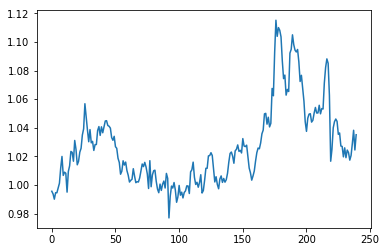

In [360]:
init = 100
position_test = []
for i, val in enumerate(list(predictions_test)):
    if val >= 0:
        position_test.append(1)
    else:
        position_test.append(-1)
        
plt.plot(np.cumprod((np.array(position_test)*actuals_test)+1));